This notebook provides examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper (http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

Note that due to limitations in what data we can access and distribute, the beta version of the hypergraph methodology presented here currently supports less functionality:

* Instead of Facebook data, we release a dataset of discussions from Reddit (the 1000 most recent threads, with at least 10 comments, from 100 highly active subreddits -- more details in the corresponding readme here: https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/tree/master/datasets/reddit-corpus). For demonstration purposes, we here use a small subset of this dataset ("reddit-corpus-small") containing 100 threads per subreddit.
* Since Reddit does not provide information on who reacted to (i.e., upvoted) each comment, we are presently unable to support reaction-edges in the hypergraph. As such, we can only compute features over in/outdegree distributions of _reply_-edges, and the feature set derived from motifs in the hypergraph is limited to counts and binary indicators or whether or not a motif is present. We will work  towards supporting reactions as well.

In [1]:
import os
os.getcwd()
os.chdir("..")
os.chdir("..")
os.getcwd()
# In order to use latest version of convokit! Get rid of this when new version is up

'/Users/macuser/Desktop/hyperconv-refactor/Cornell-Conversational-Analysis-Toolkit'

In [2]:
import convokit

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

First we download the reddit corpus:

In [4]:
convokit.__file__

'/Users/macuser/Desktop/hyperconv-refactor/Cornell-Conversational-Analysis-Toolkit/convokit/__init__.py'

In [5]:
convokit.download("reddit-corpus")

'/Users/macuser/Desktop/hyperconv-refactor/Cornell-Conversational-Analysis-Toolkit/convokit/downloads/reddit-corpus'

In [6]:
corpus = convokit.Corpus(filename=convokit.download("reddit-corpus"))

We will compute features over only the first 10 comments that occur in a thread, for  threads which are at least 10 comments long (controling for thread length in this way):

In [18]:
threads = corpus.utterance_threads(prefix_len=10)

In [15]:
def display_thread_helper(thread, root, indent=0):
    print(" "*indent + thread[root].user.name)
    children = [k for k, v in thread.items() if v.reply_to == root]
    for child in children:
        display_thread_helper(thread, child, indent=indent+4)
def display_thread(root):
    return display_thread_helper(threads[root],root)

The following are threads that come from the /r/canada subreddit. 

In [16]:
demo_threads = [
    # https://www.reddit.com/r/canada/comments/mmyld/polygamypolyamoury_laws_upheld_in_supreme_court/c32bcq8/
                't1_c32bcq8', 
    # https://www.reddit.com/r/canada/comments/mmd20/look_what_i_found_today_yes_and_it_is_in_canada/c322oa7/
                't1_c322oa7',
    # https://www.reddit.com/r/canada/comments/mo0lt/happy_thursday/c32hv0h/
                't1_c32hv0h'
               ]

We print the structure of the thread: the reply-structure (where subsequent replies in the comment tree are indented), and the authors of each comment. There are some high-level qualitative differences that you might immediately see; our goal is to automatically extract a superset of these intuitive distinctions. For instance, we notice that thread t1_c32bcq8 has a very linear structure, while t1_c322oa7 is flatter; to capture this difference, we might compute statistics on the distribution of in-degrees of nodes in the reply tree. We also intuit that some conversations involve a few people replying repeatedly to each other, whereas others may involve users stopping by to chime in once and then leaving; we'll later codify this difference via statistics on the indegrees and outdegrees of hypernodes (users).

In [19]:
for thread in demo_threads:
    print(thread)
    print('---')
    display_thread(thread)
    print()

t1_c32bcq8
---
drays
    QuirkyGroundhog
        Sajentine
            QuirkyGroundhog
                drays
                    QuirkyGroundhog
                        drays
                            QuirkyGroundhog
                                drays
                                    QuirkyGroundhog

t1_c322oa7
---
[deleted-t1_c322oa7]
    Aneeid
    veedubbin86
        figureskatingaintgay
            sirspate
        lovevolcano
    bunny1979
        veedubbin86
            bunny1979
    SoFaKiNg42

t1_c32hv0h
---
Can-eh-dian
    h00pla
        Switchbladeannie
        lengthynewt
            h00pla
                lengthynewt
                    h00pla
    thoriginal
    lengthynewt
    andrewmp



One technical note: Since we don't have access to the author of deleted comments, we make the assumption for now that each deleted comment in a particular thread was written by the same author -- a potential source of noise in the subsequent analyses.

We now extract hypergraph features. 

In [7]:
# create a hyperconvo object and use it to extract features
hc = convokit.HyperConvo(corpus)
threads_feats = hc.fit_transform(corpus)

In [8]:
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [9]:
feat_names = list(next(iter(threads_feats.values())).keys())

In [10]:
feat_names

['max[outdegree over c->c responses]',
 'max[indegree over c->c responses]',
 'argmax[outdegree over c->c responses]',
 'argmax[indegree over c->c responses]',
 'norm.max[outdegree over c->c responses]',
 'norm.max[indegree over c->c responses]',
 '2nd-largest[outdegree over c->c responses]',
 '2nd-largest[indegree over c->c responses]',
 '2nd-argmax[outdegree over c->c responses]',
 '2nd-argmax[indegree over c->c responses]',
 'norm.2nd-largest[outdegree over c->c responses]',
 'norm.2nd-largest[indegree over c->c responses]',
 'mean[outdegree over c->c responses]',
 'mean[indegree over c->c responses]',
 'mean-nonzero[outdegree over c->c responses]',
 'mean-nonzero[indegree over c->c responses]',
 'prop-nonzero[outdegree over c->c responses]',
 'prop-nonzero[indegree over c->c responses]',
 'prop-multiple[outdegree over c->c responses]',
 'prop-multiple[indegree over c->c responses]',
 'entropy[outdegree over c->c responses]',
 'entropy[indegree over c->c responses]',
 '2nd-largest /

In [11]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

For later convenience we will store feature values in a dataframe:

In [12]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)

Here are some examples of features computed over the three example threads from before:

In [13]:
C_C_indegree_feats = [x for x in feat_names if 'indegree over C->C responses' in x]
C_C_mid_outdegree_feats = [x for x in feat_names if 'outdegree over C->C mid-thread responses' in x]
motif_count_feats = [x for x in feat_names if ('count' in x) and ('mid' not in x)]

Features derived from the distribution of hypernode to hypernode indegrees (i.e., "how many other people are responding to a particular discussion participant?"). As in the paper, we compute various summary statistics over the distribution. 

As noted at the start of this notebook, since we do not have access to reaction information, these distributions encompass only the reply structure within the thread.

In [20]:
feat_df.loc[demo_threads][C_C_indegree_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
2nd-argmax[indegree over C->C responses],1.000000,2.000000,1.000000
2nd-largest / max[indegree over C->C responses],1.000000,0.750000,0.750000
2nd-largest[indegree over C->C responses],4.000000,3.000000,3.000000
argmax[indegree over C->C responses],0.000000,0.000000,0.000000
entropy[indegree over C->C responses],0.964963,1.214890,1.060857
max[indegree over C->C responses],4.000000,4.000000,4.000000
mean-nonzero[indegree over C->C responses],3.000000,2.250000,3.000000
mean[indegree over C->C responses],3.000000,1.125000,1.500000
norm.2nd-largest[indegree over C->C responses],0.444444,0.333333,0.333333
norm.max[indegree over C->C responses],0.444444,0.444444,0.444444


Features derived from the distribution of hypernode to hypernode outdegrees in the _middle_ of the thread (i.e., "beyond the root comment, how many other people is each participant responding to?"). 

In [21]:
feat_df.loc[demo_threads][C_C_mid_outdegree_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
2nd-argmax[outdegree over C->C mid-thread responses],2.000000,2.000000,3.000000
2nd-largest / max[outdegree over C->C mid-thread responses],0.750000,1.000000,1.000000
2nd-largest[outdegree over C->C mid-thread responses],3.000000,1.000000,2.000000
argmax[outdegree over C->C mid-thread responses],0.000000,1.000000,0.000000
entropy[outdegree over C->C mid-thread responses],0.974315,1.609438,1.054920
max[outdegree over C->C mid-thread responses],4.000000,1.000000,2.000000
mean-nonzero[outdegree over C->C mid-thread responses],2.666667,1.000000,1.666667
mean[outdegree over C->C mid-thread responses],2.666667,0.714286,1.000000
norm.2nd-largest[outdegree over C->C mid-thread responses],0.375000,0.200000,0.400000
norm.max[outdegree over C->C mid-thread responses],0.500000,0.200000,0.400000


Features derived from the 5 motifs considered in the paper. Note that because we do not have reply information, we instead take as features _counts_ of each motif (in the paper, we would additionally compare reply or reaction edge types within motifs of a particular form)

In [22]:
feat_df.loc[demo_threads][motif_count_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
count[DIRECIPROCAL_2TO3_TRIADS],0,0,0
count[DIRECIPROCAL_TRIADS],12,0,0
count[DIRECTED_CYCLE_1TO3_TRIADS],0,0,0
count[DIRECTED_CYCLE_TRIADS],0,0,0
count[DYADIC_TRIADS],0,3,8
count[INCOMING_1TO3_TRIADS],0,0,0
count[INCOMING_2TO3_TRIADS],0,0,0
count[INCOMING_RECIPROCAL_TRIADS],0,1,4
count[INCOMING_TRIADS],0,7,6
count[LATENT_DIRECIPROCAL_2TO3_TRIADS],0,0,0


While the features generated above can be used as is (e.g., as features in a prediction task), we can also interpret them by projecting them into a low-dimensional space. 

In [23]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [24]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [25]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [26]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

This embedding procedure produces embeddings of threads in the low-dimensional space:

In [27]:
U_df.loc[demo_threads].T

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
0,0.790590,-0.642813,-0.134897
1,-0.278791,0.119763,0.336423
2,-0.489570,0.254373,0.131722
3,0.177446,-0.314512,-0.039588
4,-0.157000,0.598868,0.424792
5,-0.003857,-0.019761,0.008154
6,0.037588,0.223140,0.818040


As well as embeddings of features:

In [28]:
V_df.loc[C_C_indegree_feats]

,0,1,2,3,4,5,6
max[indegree over C->C responses],0.055151,0.774725,-0.249438,0.265884,-0.374719,-0.098330,-0.337286
argmax[indegree over C->C responses],0.013847,-0.642982,0.551112,-0.138526,-0.469418,-0.133349,-0.159166
norm.max[indegree over C->C responses],0.055174,0.774895,-0.249117,0.265880,-0.374791,-0.098276,-0.337069
2nd-largest[indegree over C->C responses],0.433857,-0.097433,0.693970,-0.256583,-0.162368,-0.240173,0.413278
2nd-argmax[indegree over C->C responses],-0.304986,0.154071,-0.421298,-0.112129,0.712076,0.279585,0.328572
norm.2nd-largest[indegree over C->C responses],0.469250,0.019451,0.704317,-0.279475,-0.187426,-0.218802,0.349650
mean[indegree over C->C responses],0.815680,0.487607,0.254973,-0.113135,-0.089033,0.024033,-0.102910
mean-nonzero[indegree over C->C responses],0.283993,0.802421,0.248907,0.064243,-0.378550,-0.231933,0.110880
prop-nonzero[indegree over C->C responses],0.734393,-0.417310,-0.192437,0.003674,0.335222,0.364596,-0.064569
prop-multiple[indegree over C->C responses],0.347748,0.294134,0.540960,0.074269,-0.302912,-0.306228,0.555762


As in the paper, for further interpretability we can consider embeddings of _communities_ (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.

In [32]:
def get_subreddit(threads, thread_id):
    if thread_id not in threads:
        return None
    return threads[thread_id][thread_id].other["user-info"]["subreddit"]



In [33]:
subreddits = [get_subreddit(threads, thread_id) for thread_id in threads]
U_df['subreddit'] = subreddits

In [34]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [35]:
tsne = TSNE(random_state=2019)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

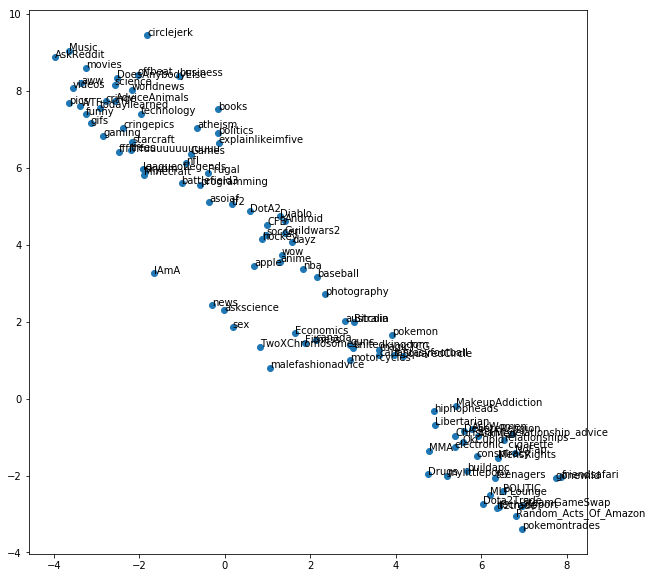

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:

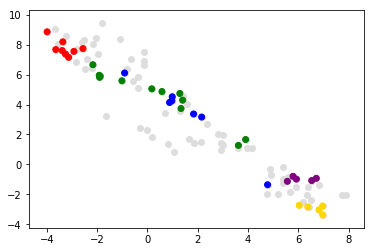

In [37]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()

For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).

There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.

Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:

In [38]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [39]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [40]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
              p2      dist
3699         wow  0.041095
3687      soccer  0.068099
3665      hockey  0.070023
3672         nba  0.079253
3616      Frugal  0.084394
3635       anime  0.087717
3653        dayz  0.100167
3642    baseball  0.112237
3618  Guildwars2  0.112429
3606         CFB  0.114084

politics
                     p2      dist
8055  explainlikeimfive  0.044598
8044              books  0.063795
8017              Games  0.064282
8074                nfl  0.075016
8016             Frugal  0.107384
8089         technology  0.140833
8043       battlefield3  0.141646
8039            atheism  0.147601
8011              DotA2  0.155388
8070             movies  0.164840

leagueoflegends
                       p2      dist
6686               skyrim  0.005894
6625            Minecraft  0.008763
6657  fffffffuuuuuuuuuuuu  0.016521
6688            starcraft  0.025136
6695                trees  0.031607
6643         battlefield3  0.034950
6660               gaming  0.049948
6652    

We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [41]:
from IPython.display import display

In [42]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [43]:
top_threads = display_dimension(0, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c30ggl3,-0.944600,0.086441,-0.135573,0.046548,-0.054287,-0.098970,0.258783,baseball
t1_c0cwg1s,-0.943965,0.187085,0.132791,-0.070912,0.039920,0.057246,0.215401,DoesAnybodyElse
t1_c324ju9,-0.938033,-0.029428,0.072331,-0.069932,-0.145093,-0.292904,0.047561,Music
t1_c325fg1,-0.937116,-0.124535,0.158336,0.004637,-0.192799,0.091704,0.188766,todayilearned
t1_c319ovj,-0.934191,0.065273,0.213005,-0.251032,0.068968,-0.066054,0.074282,starcraft
t1_c03lzt6,-0.933809,0.125289,-0.002176,-0.021931,0.210677,0.224126,-0.131148,business
t1_c2xts9o,-0.931115,-0.002961,-0.098073,-0.152935,0.028364,0.256964,0.182138,tf2
t1_c33idxo,-0.928259,0.186674,0.053496,-0.044379,0.025531,-0.043673,0.309997,technology
t1_c319g2l,-0.923559,-0.181505,0.190517,-0.022631,-0.198385,0.136668,0.138750,Economics
t1_c5k56a3,-0.923002,0.011408,0.121078,-0.033360,-0.082750,0.048855,0.350614,NoFap


,0,1,2,3,4,5,6
entropy[outdegree over C->C responses],-0.882451,-0.320321,-0.082015,-0.136001,0.200998,-0.221362,0.063636
entropy[outdegree over C->c responses],-0.882388,-0.320421,-0.082032,-0.136053,0.201065,-0.221362,0.063663
is-present[INCOMING_TRIADS],-0.881643,0.065818,0.265624,-0.241606,0.172609,0.234246,0.069125
is-present[NO_EDGE_TRIADS over mid-thread],-0.837754,-0.369189,-0.377371,-0.030626,-0.075477,-0.107286,-0.036246
is-present[NO_EDGE_TRIADS],-0.823196,-0.408150,-0.371290,-0.052998,-0.069519,-0.094472,-0.036592
is-present[SINGLE_EDGE_TRIADS over mid-thread],-0.822599,-0.417187,0.054577,-0.171345,0.209975,0.214078,0.164405
count[LATENT_SINGLE_EDGE_TRIADS],-0.818062,-0.202962,0.114923,-0.409083,0.319520,-0.062873,-0.054578
"prob[('INCOMING_TRIADS', 'INCOMING_TRIADS')]",-0.802063,0.148330,0.313713,-0.400483,0.246793,0.113217,-0.046539
"prob[('NO_EDGE_TRIADS', 'NO_EDGE_TRIADS')]",-0.794359,0.109168,-0.127948,-0.244377,0.013900,-0.398523,-0.349244
count[LATENT_NO_EDGE_TRIADS],-0.783605,0.069240,0.135792,-0.435031,0.270514,-0.266911,-0.170463


,0,1,2,3,4,5,6
subreddit,,,,,,,
worldnews,-0.947712,-0.182856,-0.021685,-0.200811,-0.124550,0.083873,-0.071162
aww,-0.945841,0.022303,0.038490,-0.215537,-0.072210,-0.089782,-0.208985
science,-0.934407,-0.149570,-0.013155,-0.236822,0.094570,0.153817,-0.125103
videos,-0.932031,0.089984,0.131271,-0.264641,0.083965,-0.018164,-0.169037
Music,-0.917989,0.301201,-0.163319,-0.010540,-0.015932,0.188884,-0.062123
todayilearned,-0.917527,-0.123888,0.124296,-0.331583,0.118976,-0.005475,-0.056690
AdviceAnimals,-0.916222,-0.188274,0.108404,-0.301045,-0.014367,0.057848,-0.138410
cringe,-0.913185,-0.144978,0.095175,-0.323073,0.136938,0.065828,-0.092490
movies,-0.911250,0.041636,-0.183888,-0.239949,0.261604,-0.069107,-0.057330


In [44]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c30ggl3
BenStrike
    TheLizardKing89
    mtg4l
        mojowo11
            rockon4life45
            three_dee
        BenStrike
    kschurmn
        BenStrike
    BdaMann

t1_c0cwg1s
[deleted-t1_c0cwg1s]
    BloodySelfCastration
    Hard2Think
        orangecrushucf
            dranek
                [deleted-t1_c0cwg1s]
            realblublu
        [deleted-t1_c0cwg1s]
    Grinyarg
    son-of-chadwardenn

t1_c324ju9
pedobare
    mathcrunk
    [deleted-t1_c324ju9]
    [deleted-t1_c324ju9]
        theemartin
            GuyFromPoland
                plzpwnpwnpwn
                theemartin
                DjQball
    eltuskio91

t1_c325fg1
dudestcool
    Ramennov
        spamgobbler
            yohanb
                [deleted-t1_c325fg1]
                Ulys
                spamgobbler
    diogenesbarrel
    H_E_Pennypacker
    [deleted-t1_c325fg1]

t1_c319ovj
Aethari
    quickclickz
        Malician
        SippieCup
        VOIDHand
    AZoned
    [deleted-t1_c319ovj]
        V

In [45]:
top_threads = display_dimension(0, ascending=False, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c3mx0hg,0.987080,0.035927,-0.027905,-0.126925,0.008540,0.003377,-0.086074,SteamGameSwap
t1_c32zahv,0.978576,0.028831,-0.067355,-0.140930,0.070039,-0.108745,-0.020720,canada
t1_c1i3zv0,0.977131,0.124725,-0.077124,-0.062144,-0.093351,0.035223,-0.099465,nba
t1_c7jwnu7,0.977131,0.124725,-0.077124,-0.062144,-0.093351,0.035223,-0.099465,Dota2Trade
t1_ccz90b3,0.976544,0.126384,-0.059976,-0.083424,-0.047263,-0.087607,0.099617,friendsafari
t1_c03wdod,0.975558,0.104193,0.055091,0.018507,-0.178933,-0.033016,-0.030753,business
t1_c6r1dur,0.968465,0.168743,-0.026846,-0.104182,-0.041921,0.124776,-0.068560,Dota2Trade
t1_c32xzoh,0.968465,0.168743,-0.026846,-0.104182,-0.041921,0.124776,-0.068560,politics
t1_c0h0oev,0.968465,0.168743,-0.026846,-0.104182,-0.041921,0.124776,-0.068560,gonewild
t1_c31puou,0.968465,0.168743,-0.026846,-0.104182,-0.041921,0.124776,-0.068560,SquaredCircle


,0,1,2,3,4,5,6
prop-multiple[outdegree over C->C responses],0.904910,0.086180,0.086823,0.185458,0.022380,0.041010,0.359994
prop-multiple[outdegree over C->c responses],0.904834,0.086251,0.086772,0.185523,0.022344,0.041047,0.360145
mean[indegree over C->C mid-thread responses],0.830975,0.232337,0.421606,-0.224280,-0.127328,-0.007629,-0.105722
mean[outdegree over C->C mid-thread responses],0.830975,0.232337,0.421606,-0.224280,-0.127328,-0.007629,-0.105722
mean[outdegree over C->c mid-thread responses],0.830719,0.232795,0.421795,-0.224081,-0.127708,-0.007574,-0.105935
mean[indegree over C->C responses],0.815680,0.487607,0.254973,-0.113135,-0.089033,0.024033,-0.102910
mean[outdegree over C->C responses],0.815680,0.487607,0.254973,-0.113135,-0.089033,0.024033,-0.102910
mean[outdegree over C->c responses],0.815350,0.488035,0.255113,-0.112952,-0.089363,0.024033,-0.103061
mean-nonzero[outdegree over C->C mid-thread responses],0.807804,0.524747,0.118751,-0.125202,-0.002183,0.187343,-0.084932
mean-nonzero[outdegree over C->c mid-thread responses],0.807485,0.525170,0.119126,-0.124946,-0.002792,0.187327,-0.085224


,0,1,2,3,4,5,6
subreddit,,,,,,,
Dota2Trade,0.975964,-0.097465,0.036472,-0.159407,-0.068205,-0.051958,0.062463
tf2trade,0.971593,0.053855,0.051510,-0.156015,-0.117780,-0.095111,0.056525
POLITIC,0.964861,0.058674,-0.110242,-0.086274,-0.162447,-0.132485,0.045421
techsupport,0.962223,0.056837,0.062432,-0.148472,-0.146435,-0.150000,0.031803
MLPLounge,0.954352,0.033191,-0.229471,-0.103267,0.002779,-0.124205,0.096724
Random_Acts_Of_Amazon,0.921621,0.308556,-0.039021,-0.206987,0.082842,-0.035186,0.054227
SteamGameSwap,0.919008,0.331382,-0.137008,-0.131769,0.006264,-0.091622,0.032287
teenagers,0.917936,0.010863,-0.371084,0.020336,-0.101040,-0.081547,0.047963
buildapc,0.886047,-0.297502,-0.161507,-0.030487,-0.168898,-0.180535,0.195649


In [46]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c3mx0hg
fcbf
    hade1223
        SeeminglyUseless
            hade1223
                SeeminglyUseless
                    hade1223
                        SeeminglyUseless
                            hade1223
                fcbf
                    fcbf

t1_c32zahv
[deleted-t1_c32zahv]
    Youre_So_Pathetic
        Zeppelin_Of_Led
            Youre_So_Pathetic
                Zeppelin_Of_Led
                    Youre_So_Pathetic
                        Zeppelin_Of_Led
        [deleted-t1_c32zahv]
            [deleted-t1_c32zahv]
                [deleted-t1_c32zahv]

t1_c1i3zv0
streptomycin
    [deleted-t1_c1i3zv0]
        EvanConover
            [deleted-t1_c1i3zv0]
                EvanConover
                    [deleted-t1_c1i3zv0]
                        EvanConover
                            [deleted-t1_c1i3zv0]
                                EvanConover
        streptomycin

t1_c7jwnu7
[deleted-t1_c7jwnu7]
    PrototypeT800
        CloneShen
            PrototypeT800
    

Another "type" of discussion surfaced at the extreme of another latent dimension corresponds to discussions which have a lot of activity in the middle of the thread, below the root  comment (indicated by the various mid-thread features which come to the fore). Subreddits here are often about more specialized topics -- e.g., programming, Bitcoin, cars.

In [47]:
top_threads = display_dimension(1,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c3qdo7w,-0.045405,-0.971959,-0.170964,-0.138730,0.001606,0.040710,-0.055669,AskWomen
t1_c3rhzg3,-0.169905,-0.968435,-0.001896,-0.004805,0.129486,0.111934,-0.062800,MakeupAddiction
t1_c33wq5t,0.051605,-0.961243,-0.131869,-0.024790,-0.160242,0.159674,-0.064585,anime
t1_c0bjccc,-0.063988,-0.960539,-0.178686,-0.134027,0.024416,0.084246,-0.125243,Frugal
t1_c32nzlp,-0.014216,-0.955519,-0.104559,-0.031408,0.065578,0.264752,-0.021633,explainlikeimfive
t1_c321hcu,0.067081,-0.955017,-0.113132,-0.129669,-0.085840,0.178277,-0.121154,fffffffuuuuuuuuuuuu
t1_c0ivmu1,0.193766,-0.954552,-0.010263,0.143978,0.113039,0.121115,0.054813,gonewild
t1_c02n1ro,-0.055532,-0.953837,-0.007509,-0.114304,-0.153619,0.207129,0.086530,science
t1_c0k8kxt,-0.063715,-0.952714,-0.002029,-0.097671,-0.091225,0.169619,0.204060,photography
t1_c510aab,-0.183078,-0.951728,-0.051615,-0.211756,-0.054693,-0.090985,-0.043832,dayz


,0,1,2,3,4,5,6
entropy[indegree over C->C responses],-0.218506,-0.809326,-0.045337,-0.216367,0.443384,0.211050,0.085119
2nd-largest[outdegree over c->c mid-thread responses],0.189574,-0.773378,0.330519,-0.290943,0.089243,0.261795,-0.309122
is-present[LATENT_DYADIC_TRIADS],-0.163007,-0.730735,-0.471460,0.275052,-0.081703,-0.102239,0.352701
is-present[LATENT_UNIDIRECTIONAL_TRIADS over mid-thread],-0.374897,-0.699747,0.081820,0.140356,0.080262,0.546516,-0.195680
entropy[outdegree over C->c mid-thread responses],-0.386964,-0.692914,0.396447,-0.206800,-0.106771,-0.341705,0.205012
entropy[outdegree over C->C mid-thread responses],-0.386971,-0.692904,0.396493,-0.206770,-0.106802,-0.341696,0.204975
is-present[LATENT_DYADIC_TRIADS over mid-thread],-0.062864,-0.688777,-0.493392,0.210774,-0.032631,-0.146084,0.459747
is-present[DYADIC_TRIADS],-0.302869,-0.681072,-0.077422,-0.180981,0.258933,-0.245874,0.527411
is-present[LATENT_OUTGOING_3TO1_TRIADS],0.069404,-0.674525,-0.560115,0.341895,0.001882,0.186490,0.273489
"prob[('UNIDIRECTIONAL_TRIADS', 'OUTGOING_3TO1_TRIADS')]",0.102140,-0.660903,-0.534127,0.195995,0.038015,0.130146,0.459005


,0,1,2,3,4,5,6
subreddit,,,,,,,
dayz,-0.280967,-0.876594,-0.194209,-0.211158,0.001046,-0.208805,0.163506
Bitcoin,0.152966,-0.863180,-0.332878,-0.066191,-0.131025,-0.068305,0.307409
wow,-0.355826,-0.838358,-0.341493,-0.118775,0.018489,-0.065874,0.187451
nba,-0.238125,-0.825751,-0.255661,-0.096645,-0.089347,-0.156192,0.392874
australia,0.096157,-0.808951,-0.507257,0.039765,-0.089063,-0.010222,0.263484
hockey,-0.400448,-0.806786,-0.224659,-0.184747,0.154700,-0.062517,0.276215
baseball,-0.166543,-0.802639,-0.399533,-0.012358,0.095565,-0.021039,0.398347
guns,0.183544,-0.793258,-0.328622,0.056758,-0.304342,-0.260184,0.255967
canada,0.020115,-0.771619,-0.314451,0.087729,-0.518524,-0.048362,0.162535


In [48]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c3qdo7w
UselessPenguin
    KristieKrunchBar
        UselessPenguin
            KristieKrunchBar
                njtrafficsignshopper
                    KristieKrunchBar
        Impudence
            CryingBlood
    CryingBlood
        pichincha

t1_c3rhzg3
thepinkyoohoo
    serial_lurker
        misseff
            serial_lurker
                laurel_flowers
    ToTheOcean
        serial_lurker
            ToTheOcean
            sh33p3r10
                [deleted-t1_c3rhzg3]

t1_c33wq5t
Fabien4
    deadskin
        NorrisOBE
            deadskin
        Fabien4
            [deleted-t1_c33wq5t]
                ravenex
                    deadskin
                        Vellon221
            deadskin

t1_c0bjccc
magpi3
    [deleted-t1_c0bjccc]
    neoform3
        magpi3
            neoform3
                space_island
                    [deleted-t1_c0bjccc]
                        0ddb411
        mordaunt0
            neoform3

t1_c32nzlp
[deleted-t1_c32nzlp]
    BeyondSight
   

The following discussion type consists of threads with a particularly active latecomer (indicated by the argmax[outdegree... features). 

In [49]:
top_threads = display_dimension(2,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c518drd,-0.033348,0.052128,-0.959258,0.228890,0.099495,-0.116794,0.008002,AskMen
t1_c136nqj,0.116597,-0.022682,-0.948975,0.170882,0.181031,-0.122928,-0.090843,aww
t1_c2zuih0,0.081354,0.000982,-0.948852,0.237508,0.170411,-0.024854,-0.083625,Drugs
t1_c30j56n,-0.057719,0.120257,-0.948603,0.212414,0.191752,-0.018687,-0.010968,DebateReligion
t1_c0bkteh,-0.025884,-0.040386,-0.946976,0.231543,0.167771,0.045410,-0.130823,tf2
t1_c2y99cl,-0.008718,0.027909,-0.945283,0.218461,0.148116,0.008651,-0.189330,Christianity
t1_c2a61a9,0.205329,-0.015751,-0.944376,0.116334,0.221677,-0.044891,0.032504,explainlikeimfive
t1_c30qqdu,0.105930,-0.164930,-0.943170,0.031921,0.137248,-0.209699,-0.090426,books
t1_c31c189,0.069327,0.132923,-0.941010,0.239096,0.156089,-0.096335,-0.034860,TwoXChromosomes
t1_c2mrt9z,0.093440,-0.117877,-0.940599,0.225349,0.130912,0.063049,-0.144059,fantasyfootball


,0,1,2,3,4,5,6
count[LATENT_OUTGOING_3TO1_TRIADS over mid-thread],0.206360,-0.377293,-0.727020,0.434544,-0.155414,0.271156,0.000396
count[DIRECIPROCAL_TRIADS],0.289180,-0.300562,-0.705525,0.374104,-0.365700,-0.230546,-0.037833
count[LATENT_DIRECIPROCAL_TRIADS],0.291304,-0.301553,-0.693702,0.399590,-0.344915,-0.249858,-0.043805
"prob[('INCOMING_1TO3_TRIADS', 'DIRECIPROCAL_TRIADS')]",0.235194,-0.379152,-0.683622,0.438075,-0.276830,-0.253603,-0.027023
"prob[('DIRECIPROCAL_TRIADS', 'DIRECIPROCAL_TRIADS')]",0.148703,-0.400728,-0.677697,0.404496,-0.375482,-0.228576,0.034375
is-present[DIRECIPROCAL_TRIADS],0.148809,-0.400872,-0.676766,0.406516,-0.373921,-0.229998,0.034273
count[LATENT_OUTGOING_3TO1_TRIADS],0.303153,-0.484409,-0.670475,0.385813,-0.189014,0.054700,0.190627
"prob[('OUTGOING_3TO1_TRIADS', 'DIRECIPROCAL_TRIADS')]",0.238744,-0.356041,-0.668203,0.437599,-0.293250,-0.289297,0.092519
is-present[LATENT_OUTGOING_3TO1_TRIADS over mid-thread],0.071692,-0.506873,-0.667718,0.415231,-0.081573,0.328204,0.072824
"prob[('OUTGOING_TRIADS', 'OUTGOING_3TO1_TRIADS')]",0.279802,-0.406710,-0.648143,0.527505,-0.149896,-0.091536,0.164619


,0,1,2,3,4,5,6
subreddit,,,,,,,
malefashionadvice,-0.129437,-0.181894,-0.833903,0.353645,-0.245518,-0.256947,0.058310
TwoXChromosomes,-0.422801,-0.373722,-0.669232,0.090446,-0.334871,-0.309047,0.133679
MakeupAddiction,0.534310,-0.214019,-0.641301,0.332091,-0.312406,-0.159782,0.155015
friendsafari,0.427083,0.597436,-0.603589,0.295607,-0.081050,0.004731,0.048737
unitedkingdom,0.184988,-0.708751,-0.594718,0.086070,-0.182076,-0.172204,0.198868
SquaredCircle,0.362826,-0.535191,-0.588278,-0.189254,0.058908,-0.398349,0.194648
hiphopheads,0.556381,-0.394327,-0.552572,0.277406,-0.250500,-0.000512,0.299843
fantasyfootball,0.300035,-0.560165,-0.538052,-0.137456,-0.088968,-0.424667,0.315504
photography,-0.112044,-0.755726,-0.525217,0.036597,-0.001967,-0.031891,0.371633


In [50]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c518drd
MechaSixVII
    [deleted-t1_c518drd]
        MechaSixVII
    TBizzcuit
        MechaSixVII
            TBizzcuit
                MechaSixVII
                    dipset33
    LEIFey
    n0ggy

t1_c136nqj
zapdagas
    Xipro
        zapdagas
            WillPoopForFood
                zapdagas
                    fuzzybeard
                        zapdagas
                            fuzzybeard
    belladonnadiorama
    StarDXB

t1_c2zuih0
ttruth1
    JoJoMunny
    kreuelt
        ttruth1
            MadCervantes
                ttruth1
                    [deleted-t1_c2zuih0]
                        ttruth1
                            [deleted-t1_c2zuih0]
    shakalaka

t1_c30j56n
NYKevin
    tannat
    [deleted-t1_c30j56n]
        NYKevin
            Brian
    stieruridir
        NYKevin
            stieruridir
                NYKevin
    namer98

t1_c0bkteh
halbowitz
    [deleted-t1_c0bkteh]
        halbowitz
    ChokingVictim
        halbowitz
            ChokingVictim
    

And as a final example, this dimension splits the space between threads that are perfectly "flat": many comments replying to a single root (note that there are many threads of this form which share the exact same hypergraph topology as a result); and deeper discussions where multiple participants are highly active (indicated by e.g., the 2nd largest / largest, and prop-multiple features). At a higher level of aggregation we see a split between subreddits for making trades, and subreddits which are potentially more discussion-based.

In [51]:
top_threads = display_dimension(5,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c34mo3e,0.072543,-0.021199,-0.302648,-0.096663,-0.201071,-0.918544,0.095901,Games
t1_c2zo8xy,-0.036210,0.332096,-0.117555,-0.109682,-0.307854,-0.876132,-0.013059,Fitness
t1_c4tjwwx,0.105715,-0.139455,-0.122830,-0.213991,-0.151595,-0.863514,0.373979,dayz
t1_c31aofx,-0.000975,-0.062097,-0.431751,-0.028348,-0.188473,-0.860656,0.180774,DebateReligion
t1_c1v28t8,0.104502,-0.152152,-0.160817,-0.161892,-0.186855,-0.858412,0.376924,Guildwars2
t1_c31unux,-0.003800,-0.109571,-0.398287,-0.011664,-0.229106,-0.856255,0.208684,videos
t1_c076o7t,-0.109668,-0.277402,-0.233924,-0.041568,-0.273735,-0.852847,0.228680,news
t1_c0jag19,-0.158731,-0.100786,-0.252279,-0.261322,-0.159206,-0.852257,-0.284648,aww
t1_c30tzpf,-0.115120,-0.368877,-0.168296,-0.305451,-0.030166,-0.852036,-0.046672,Minecraft
t1_c0llfvp,-0.240660,-0.306128,-0.098426,-0.312770,-0.079191,-0.851057,0.101428,hockey


,0,1,2,3,4,5,6
count[INCOMING_1TO3_TRIADS],-0.140036,-0.224592,-0.255616,0.314347,-0.586442,-0.611282,0.219580
count[INCOMING_1TO3_TRIADS over mid-thread],0.013389,-0.428805,0.122948,0.140952,-0.625998,-0.567958,0.257902
prop-nonzero[outdegree over C->c responses],0.269519,0.059854,-0.355420,0.538602,-0.442033,-0.508618,-0.230817
prop-nonzero[outdegree over C->C responses],0.269519,0.059854,-0.355420,0.538602,-0.442033,-0.508618,-0.230817
"prob[('INCOMING_1TO3_TRIADS', 'INCOMING_1TO3_TRIADS')]",-0.504891,-0.493589,0.058440,0.133710,-0.423628,-0.482465,0.260631
is-present[INCOMING_1TO3_TRIADS over mid-thread],-0.121308,-0.597537,0.114730,0.141935,-0.528032,-0.469018,0.310048
is-present[LATENT_DIRECIPROCAL_2TO3_TRIADS over mid-thread],0.040383,-0.026724,0.295554,0.614947,0.534711,-0.467428,-0.166550
is-present[MotifType.TRIRECIPROCAL_TRIADS over mid-thread],0.040383,-0.026724,0.295554,0.614947,0.534711,-0.467428,-0.166550
is-present[LATENT_TRIRECIPROCAL_TRIADS over mid-thread],0.040383,-0.026724,0.295554,0.614947,0.534711,-0.467428,-0.166550
count[LATENT_TRIRECIPROCAL_TRIADS over mid-thread],0.041774,-0.023778,0.297258,0.614278,0.537286,-0.461819,-0.173309


,0,1,2,3,4,5,6
subreddit,,,,,,,
IAmA,-0.155059,-0.496959,0.240951,-0.168711,-0.608611,-0.433327,-0.290324
fantasyfootball,0.300035,-0.560165,-0.538052,-0.137456,-0.088968,-0.424667,0.315504
SquaredCircle,0.362826,-0.535191,-0.588278,-0.189254,0.058908,-0.398349,0.194648
atheism,-0.678404,-0.228231,-0.233172,-0.366718,-0.346164,-0.391116,-0.161327
cars,0.336392,-0.715919,-0.346784,-0.025033,-0.185402,-0.337503,0.324241
Fitness,-0.104205,-0.688345,-0.464242,0.076071,-0.424630,-0.336789,0.016639
Android,-0.362465,-0.674711,-0.434409,-0.264634,0.119586,-0.336007,0.165654
TwoXChromosomes,-0.422801,-0.373722,-0.669232,0.090446,-0.334871,-0.309047,0.133679
pokemon,0.304426,-0.764308,-0.328182,-0.313574,-0.020937,-0.308432,0.146825


In [52]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c34mo3e
pakoito
    Campstar
        pakoito
            Campstar
                pakoito
                sodiumlaurethsulfate
    Pieloi
    SolInvictus
        Campstar
            SolInvictus

t1_c2zo8xy
ziptnf
    TheGreatCthulhu
        ziptnf
            TheGreatCthulhu
                ziptnf
                    [deleted-t1_c2zo8xy]
                        TheGreatCthulhu
            skripklubbin
    themathemagician
    [deleted-t1_c2zo8xy]

t1_c4tjwwx
Brimshae
    siegewolf
        Brimshae
            siegewolf
                OutsanityDotCom
                    siegewolf
                        OutsanityDotCom
                        [deleted-t1_c4tjwwx]
    OutsanityDotCom
    JohnStrangerGalt

t1_c31aofx
MrKequc
    mrdrzeus
        MrKequc
            mrdrzeus
                MrKequc
                    kadmylos
        JPozz
            mrdrzeus
    HapkidoJosh
    davorzdralo

t1_c1v28t8
phantomgoose
    Zarokima
        phantomgoose
            Zarokima
             

In [53]:
top_threads = display_dimension(5, ascending=False, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c09d13j,-0.098375,-0.014969,0.011434,0.113692,0.096336,0.976006,-0.123177,sex
t1_c310ytu,-0.068629,0.021144,0.011221,0.193106,0.097295,0.973011,-0.034785,nfl
t1_c2zpw3s,-0.077307,-0.007021,0.130159,0.126157,0.127464,0.971627,0.028496,Minecraft
t1_c32ztz5,-0.076361,-0.067070,0.011288,0.169694,0.084256,0.969819,-0.114452,funny
t1_c25hn3s,0.089520,0.142400,0.145320,0.043580,0.066414,0.969676,-0.063317,SquaredCircle
t1_c29fouo,-0.026927,-0.167057,0.013359,0.159898,-0.006921,0.968554,-0.086462,explainlikeimfive
t1_c02t9uk,-0.085863,-0.081267,0.083060,0.165284,0.126846,0.967168,-0.017376,science
t1_c30jcl1,-0.152958,0.120734,0.126875,0.088451,0.070019,0.964531,-0.053706,science
t1_c33xaee,0.058934,0.007270,0.015316,0.133093,0.151977,0.964392,0.159303,atheism
t1_c32uuye,-0.110437,-0.002685,-0.071255,0.114758,0.140701,0.963417,-0.146904,pics


,0,1,2,3,4,5,6
count[OUTGOING_TRIADS],-0.173308,0.017460,0.206987,0.180206,-0.038820,0.919574,0.217296
"prob[('OUTGOING_TRIADS', 'OUTGOING_TRIADS')]",-0.221014,-0.036319,0.245149,0.103610,0.028823,0.903900,0.247254
is-present[OUTGOING_TRIADS over mid-thread],-0.155752,-0.121449,-0.088440,0.352645,-0.030826,0.901443,0.123537
is-present[OUTGOING_TRIADS],-0.203266,-0.037589,0.242908,0.127506,0.012637,0.898279,0.273756
count[OUTGOING_TRIADS over mid-thread],-0.125408,-0.068139,-0.157887,0.398753,-0.070134,0.888289,0.041483
"prob[('INCOMING_2TO3_TRIADS', 'INCOMING_2TO3_TRIADS')]",-0.095972,0.054616,0.270938,0.351437,-0.157531,0.864546,0.136508
is-present[INCOMING_2TO3_TRIADS],-0.089421,0.048503,0.272609,0.361571,-0.136631,0.862834,0.146465
count[INCOMING_2TO3_TRIADS],-0.056364,0.139232,0.262317,0.392207,-0.197508,0.842339,0.079104
"prob[('DIRECTED_CYCLE_TRIADS', 'DIRECTED_CYCLE_TRIADS')]",-0.025101,-0.195691,0.233265,0.239931,0.380557,0.835333,-0.080562
is-present[DIRECTED_CYCLE_TRIADS over mid-thread],-0.036476,-0.161755,0.187220,0.289102,0.370081,0.833618,-0.148305


,0,1,2,3,4,5,6
subreddit,,,,,,,
news,-0.324040,-0.524559,-0.277171,-0.123444,-0.314033,0.652983,0.052639
circlejerk,-0.047805,-0.146782,0.245618,-0.591732,0.312072,0.487507,-0.480252
business,-0.735121,-0.417268,-0.089269,-0.036641,-0.214276,0.471893,-0.087036
Drugs,0.648639,-0.333702,-0.154526,0.282173,-0.467965,0.376873,-0.058194
offbeat,-0.805308,-0.282274,0.085331,-0.311035,-0.021270,0.294494,-0.283898
askscience,-0.512109,-0.595850,-0.226709,0.083097,-0.479529,0.291270,0.098078
Economics,-0.062766,-0.710951,-0.446509,0.139553,-0.461857,0.217889,0.104774
Music,-0.917989,0.301201,-0.163319,-0.010540,-0.015932,0.188884,-0.062123
MMA,0.716291,-0.540572,-0.285448,-0.059338,-0.255922,0.183834,0.102062


In [54]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c09d13j
DUG1138
    [deleted-t1_c09d13j]
        waxpoet
            [deleted-t1_c09d13j]
                [deleted-t1_c09d13j]
    cowgod42
    tarafuji
        eitherorsayyes
            [deleted-t1_c09d13j]
        [deleted-t1_c09d13j]

t1_c310ytu
Gian_Doe
    jamdog316
        Gian_Doe
    [deleted-t1_c310ytu]
        [deleted-t1_c310ytu]
            [deleted-t1_c310ytu]
    my_cat_joe
        Dungrove_Elder
            Gian_Doe
            [deleted-t1_c310ytu]

t1_c2zpw3s
lamefork
    [deleted-t1_c2zpw3s]
        hagbardceline
    Fredo5227
        [deleted-t1_c2zpw3s]
            Redditdad6
                [deleted-t1_c2zpw3s]
                    Redditdad6
            [deleted-t1_c2zpw3s]
    pancakehiatt

t1_c32ztz5
Stratocatser
    imcostalong
        [deleted-t1_c32ztz5]
            [deleted-t1_c32ztz5]
        [deleted-t1_c32ztz5]
    Pride_Of_Scotland
        selfish_king
            [deleted-t1_c32ztz5]
                will_holmes
    [deleted-t1_c32ztz5]

t1_c25hn3s
Joh

This dimension highlights two interesting points:

* discussion structures, as in the Facebook data, might help us draw interesting parallels between subreddits which are topically different (e.g., politics, business and sex -- certainly a somewhat clickbaity grouping). Of course, one should delve deeper into the interpretation than what we've presented here in order to make sense of this.
* There might be aspects of the _tree_ structure that we could delve into further. Reddit, in contrast to Facebook, explicitly renders all branching in the discussion tree beyond the first reply. Might there be different interactional dynamics on the two platforms as a result of this, or additional features we may have  presently neglected to include, that become especially salient on Reddit?